# L9d: Modern Hopfield Networks

___
In this lab, we'll implement a modern version of a Hopfield Network, which is a type of recurrent neural network. Hopfield Networks are used for associative memory, where the network can recall a pattern from a partial input. The modern version of Hopfield Networks uses continuous values instead of binary values, and it can store multiple patterns. 

We'll use the following paper to guide our implementation:
* [Ramsauer, H., Schafl, B., Lehner, J., Seidl, P., Widrich, M., Gruber, L., Holzleitner, M., Pavlovi'c, M., Sandve, G.K., Greiff, V., Kreil, D.P., Kopp, M., Klambauer, G., Brandstetter, J., & Hochreiter, S. (2020). Hopfield Networks is All You Need. ArXiv, abs/2008.02217.](https://arxiv.org/abs/2008.02217)

## Tasks
Before we get started, we'll quickly review modern Hopfied Networks. Then, you'll execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!

* __Task 1: Setup, Data, Constants (5 min)__: Let's take 5 minutes to load [a Simpsons character library from Kaggle](https://www.kaggle.com/datasets/kostastokis/simpsons-faces) that our Hopfield network will memorize.
*  __Task 2: Build a Modern Network Model (5 min)__: In this task, we'll formulate the image dataset we give the network and then create a model of a modern Hopfield network. We'll also quickly check to ensure we are doing what we think we are doing.
* __Task 3: Retrieve a memory from the network (30 min)__: In this task, we will retrieve a memory from the modern Hopfield network starting from a random state vector $\mathbf{s}_{\circ}$. We'll corrupt an image (by cutting off some fraction of the image) and then see if the model recovers the correct memory given the corrupted starting point. 

Let's get started!
___

## Background
A modern Hopfield network addresses many of the perceived limitations of the original Hopfield network. The original Hopfield network was limited to binary values and could only store a limited number of patterns. The modern Hopfield network uses continuous values and can store a large number of patterns.
* For a detailed discussion of the key milestones in the development of modern Hopfield networks, check out [Hopfield Networks is All You Need Blog, GitHub.io](https://ml-jku.github.io/hopfield-layers/)

### Algorithm
The user provides a set of memory vectors $\mathbf{X} = \left\{\mathbf{x}_{1}, \mathbf{x}_{2}, \ldots, \mathbf{x}_{m}\right\}$, where $\mathbf{x}_{i} \in \mathbb{R}^{n}$ is a memory vector of size $n$ and $m$ is the number of memory vectors. Further, the user provides an initial _partial memory_ $\mathbf{s}_{\circ} \in \mathbb{R}^{n}$, which is a vector of size $n$ that is a partial version of one of the memory vectors and specifies the _temperature_ $\beta$ of the system.

__Initialize__ the network with the memory vectors $\mathbf{X}$, and the inverse temperature $\beta$. Set current state to the initial state $\mathbf{s} \gets \mathbf{s}_{\circ}$

Until convergence __do__:
   1. Compute the _current_ probability vector defined as $\mathbf{p} = \texttt{softmax}(\beta\cdot\mathbf{X}^{\top}\mathbf{s})$ where $\mathbf{s}$ is the _current_ state vector, and $\mathbf{X}^{\top}$ is the transpose of the memory matrix $\mathbf{X}$.
   2. Compute the _next_ state vector $\mathbf{s}^{\prime} = \mathbf{X}\mathbf{p}$ and the _next_ probability vector $\mathbf{p}^{\prime} = \texttt{softmax}(\beta\cdot\mathbf{X}^{\top}\mathbf{s}^{\prime})$.
   3. If $\mathbf{p}^{\prime}$ is _close_ to $\mathbf{p}$ or we run out of iterations, then __stop__. For example, $\lVert \mathbf{p}^{\prime} - \mathbf{p}\rVert_{2}^{2} \leq \epsilon$ for some small $\epsilon > 0$.
   4. Otherwise, update the state $\mathbf{s} \gets\mathbf{s}^{\prime}$, and __go back to__ step 1.

   
This algorithm is implemented in [the `recover(...)` method](src/Compute.jl).


## Task 1: Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [4]:
include("Include.jl"); # load a bunch of libs, including the ones we need to work with images

In [5]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end]; # helper function to get the file extension

### Load the Simpsons characters data set
In this example, we'll use a Hopfield network to learn a single image pattern from [the MNIST Simpsons dataset](https://github.com/alvarobartt/simpsons-mnist). The goal is to _train_ the network to recognize and retrieve a Simpsons character input from a noisy input.

Load a training image dataset that we'll encode into the modern Hopfield network. Save the images (training data) in the `training_image_dictionary` variable.
* _What's in the training dataset_? The `training_image_dictionary` will be of type `Dict{Int64, Array{Gray{N0f8},2}}` where the key is the image index and the value is the image data itself. The image is a 2D array of `Gray` values.

However, before we load the training data, let's set some constants. The comment next to each constant describes it, its permissible values, units, etc.

In [7]:
number_of_images_to_memorize = 24; # how many images do we want to memorize?
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 200; # number of rows in the image
number_of_cols = 200; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?
β = 10.0; # Inverse temperature of the system. 

`Unhide` the code blocks below to see how we constructed and populated the `training_image_dictionary` variable. First, we load all the images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},2}}`, and then we'll convert these to a vector format below.

In [9]:
training_image_dictionary = let
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},2}}();
    files = readdir(joinpath(_PATH_TO_IMAGES)); 
    number_of_files = length(files);
    imagecount = 1;
    for i ∈ 1:number_of_files
        filename = files[i];
        ext = file_extension(filename)
        if (ext == "png")
            training_image_dictionary[imagecount] = joinpath(_PATH_TO_IMAGES, filename) |> x-> FileIO.load(x) |> img-> Gray.(img); # convert to grayscale
            imagecount += 1
        end
    end
    training_image_dictionary
end;

In [10]:
training_image_dictionary

Dict{Int64, Matrix{Gray{N0f8}}} with 1000 entries:
  719 => [0.576 0.576 … 0.651 0.647; 0.576 0.576 … 0.651 0.647; … ; 0.682 0.682…
  699 => [0.314 0.314 … 0.278 0.278; 0.333 0.333 … 0.278 0.278; … ; 0.133 0.224…
  831 => [0.373 0.373 … 0.561 0.561; 0.373 0.373 … 0.561 0.561; … ; 0.235 0.235…
  319 => [0.769 0.769 … 0.596 0.592; 0.769 0.769 … 0.596 0.592; … ; 0.435 0.435…
  687 => [0.659 0.659 … 0.671 0.671; 0.659 0.663 … 0.671 0.671; … ; 0.396 0.396…
  185 => [0.729 0.729 … 0.729 0.729; 0.725 0.725 … 0.725 0.725; … ; 0.608 0.608…
  823 => [0.471 0.471 … 0.376 0.376; 0.467 0.467 … 0.376 0.376; … ; 0.471 0.471…
  420 => [0.349 0.349 … 0.467 0.467; 0.349 0.349 … 0.467 0.467; … ; 0.165 0.165…
  525 => [0.192 0.2 … 0.196 0.2; 0.2 0.22 … 0.2 0.2; … ; 0.357 0.353 … 0.255 0.…
  365 => [0.573 0.573 … 0.451 0.388; 0.569 0.569 … 0.012 0.008; … ; 0.122 0.357…
  638 => [0.063 0.0 … 0.192 0.192; 0.063 0.0 … 0.192 0.192; … ; 0.376 0.427 … 0…
  263 => [0.086 0.086 … 0.412 0.227; 0.086 0.086 … 0.396 0

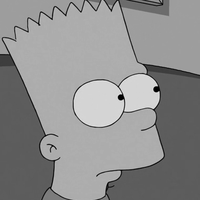

In [11]:
img = training_image_dictionary[600] # TODO: pick an example image. We have 1000 images to choose from!

Next, we vectorize the images stored in the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},2}}` dictionary:
* _What do we mean by vectorize_? Each $n\times{n}$ image contains the grayscale values at each pixel. We convert these arrays into an $n^{2}$ vector of values. The converted data is stored in the `training_image_dataset::Dict{Int64, Vector{Float32}}` dictionary.
* _What's the deal with Float32_? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/), which has different memory constraints.

In [13]:
training_image_dataset = let
    training_image_dataset = Dict{Int, Vector{Float32}}();
    number_of_training_examples = length(training_image_dictionary);
    for t ∈ 1:number_of_training_examples
        X = training_image_dictionary[t];
        D = Array{Float32,1}(undef, number_of_pixels);
        linearindex = 1;
        for row ∈ 1:number_of_rows
            for col ∈ 1:number_of_cols
                D[linearindex] = X[row,col];
                linearindex+=1;
            end
        end
        training_image_dataset[t] = D;
    end
    training_image_dataset
end;

In [14]:
training_image_dataset

Dict{Int64, Vector{Float32}} with 1000 entries:
  719 => [0.576471, 0.576471, 0.576471, 0.576471, 0.576471, 0.576471, 0.576471,…
  699 => [0.313726, 0.313726, 0.309804, 0.305882, 0.309804, 0.309804, 0.309804,…
  831 => [0.372549, 0.372549, 0.372549, 0.372549, 0.376471, 0.376471, 0.364706,…
  319 => [0.768627, 0.768627, 0.768627, 0.764706, 0.780392, 0.72549, 0.341176, …
  687 => [0.658824, 0.658824, 0.658824, 0.658824, 0.658824, 0.658824, 0.658824,…
  185 => [0.729412, 0.729412, 0.729412, 0.729412, 0.729412, 0.729412, 0.729412,…
  823 => [0.470588, 0.470588, 0.470588, 0.470588, 0.478431, 0.478431, 0.470588,…
  420 => [0.34902, 0.34902, 0.34902, 0.34902, 0.34902, 0.34902, 0.34902, 0.3490…
  525 => [0.192157, 0.2, 0.211765, 0.223529, 0.235294, 0.239216, 0.239216, 0.23…
  365 => [0.572549, 0.572549, 0.564706, 0.560784, 0.560784, 0.560784, 0.560784,…
  638 => [0.0627451, 0.0, 0.254902, 0.819608, 0.792157, 0.792157, 0.792157, 0.7…
  263 => [0.0862745, 0.0862745, 0.0862745, 0.0862745, 0.08627

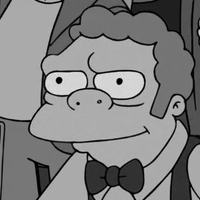

In [15]:
training_image_dataset[3] |> s-> decode(s, number_of_rows=number_of_rows,number_of_cols=number_of_cols) |> img -> Gray.(img)

Next, let's generate a _random set of image indexes_ that we encode into the model. We'll store this collection in the `image_index_set_to_encode::Set{Int64}` variable.
* _How do we build this set_? We specify the number of images that we want in the `number_of_images_to_memorize::Int` variable; then we iterate using [a `while-loop`](https://docs.julialang.org/en/v1/base/base/#while) until we generate the required number of indexes _randomly_. We stop the loop once we hit our target number. Fun data structure question: why do we use [a Julia `Set`](https://docs.julialang.org/en/v1/base/collections/#Base.Set) instead of an array?

`Unhide` the code block below to see how we generated the `image_index_set_to_encode::Set{Int}` index set.

In [17]:
image_index_set_to_encode = let

    # how many images do we want to encode?
    number_of_possible_images = length(training_image_dataset);
    image_index_set_to_encode = Set{Int64}();

    is_ok_to_stop = false; # iteration flag
    while (is_ok_to_stop == false)
        
        # generate a random index -
        j = rand(1:number_of_possible_images);
        push!(image_index_set_to_encode, j); # add to the image set -

        # check: have we hit the number that we want?
        if (length(image_index_set_to_encode) ≥ number_of_images_to_memorize)
            is_ok_to_stop = true;
        end
    end

    # return 
    image_index_set_to_encode;
end;

In [18]:
image_index_set_to_encode

Set{Int64} with 24 elements:
  402
  329
  136
  985
  426
  707
  847
  319
  798
  507
  542
  96
  517
  635
  953
  670
  21
  261
  675
  351
  518
  322
  127
  416

## Task 2: Can we recover a corrupted memory?
In this task, we'll formulate the image dataset we give the network and then create a model of a modern Hopfield network. Finally, we'll perform some quick checks to make sure we are doing what we think we are doing.

Let's start by creating a model of a modern Hopfield network. 
* We'll construct [a `MyModernHopfieldNetworkModel` instance](src/Types.jl) using a custom [`build(...)` function](src/Factory.jl). The [`build(...)` method](src/Factory.jl) takes the type of thing we want to build, the (linearized) image library we want to encode, and the (inverse) system temperature $\beta$ as inputs — images along the columns.
* The [`build(...)` function](src/Factory.jl) returns a `MyModernHopfieldNetworkModel` instance, where the image library is stored in the `X::Array{Float32,2}` field, and the system temperature is stored in the `β::Float64` field.

We'll store the problem instance in the `model::MyModernHopfieldNetworkModel` variable.

In [20]:
model = let

    # initialize -
    number_of_images_to_learn = length(image_index_set_to_encode);
    linearimagecollection = Array{Float32,2}(undef, number_of_pixels, number_of_images_to_learn); # images on columns
    index_vector = image_index_set_to_encode |> collect |> sort; # # turn our set into a sorted vector - we'll process this in the sorted order 

    # populate the data array that we give to the model
    for k ∈ eachindex(index_vector)
        j = index_vector[k]; # what image index will we load?
        sₖ = training_image_dataset[j]; # original data, vectorized
        
        for i ∈ 1:number_of_pixels
            linearimagecollection[i,k] = sₖ[i];  # fill the columns of the array with the image data
        end
    end
    
    # build model -
    model = build(MyModernHopfieldNetworkModel, (
            memories = linearimagecollection, # this is the data we want to memorize. Images on columns
            β = β, # Inverse temperature of the system. A big beta means we are more likely to get the right answer
    ));

    model; # return the model to the calling scope
end;

__Check__: Let's do a quick check to make sure we are doing what we think we are doing. Let's check what's stored in the columns of the `model.X` field. These should be the images that we are trying to encode.

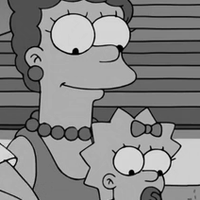

In [22]:
let
    X = model.X; # get the training data in the model
    index_to_check = 4; # what index do we want to check?
    X[:,index_to_check] |> s-> decode(s, number_of_rows = number_of_rows, 
        number_of_cols = number_of_cols) |> img -> Gray.(img) # decode (turn back into a array) and display
end

## Task 3: Retrieve a memory from the network
In this task, we will retrieve a memory from the Hopfield network starting from a random state vector $\mathbf{s}_{\circ}$. 
* _What should we expect_: We are _guaranteed_ that the network will converge to a local minimum, but we are not guaranteed that the local minimum is the same as the original image. Convergence should occur in less than or equal to the number of pixels in the image.

Let's start by specifying which image we are trying to recover in the `imageindextorecover::Int` variable.

In [24]:
imageindextorecover = 4; # which element of the index vector will we choose?

Next, build a corrupted initial condition vector using this image, which we'll store in the `sₒ::Array{Float32,1}` variable. We'll iterate through each pixel from the original image; sometimes, we'll make a mistake and replace the correct pixel value with an incorrect value.
* _What is the $\theta$ parameter_? The $\theta$ hyperparameter controls how often we make mistakes. Its interpretation depends upon our _mistake_ model. For example, if we are cutting off some fraction of the image, then $\theta$ describes the fraction of the image we are cutting off. Alternatively, if we add noise, $1 - \theta$ describes the fraction of the original image we are keeping.

Whichever model we use, the $\theta\in[0,1]$. We store the corrupted image in the `sₒ::Array{Float32,1}` variable.

In [26]:
sₒ = let

    # initialize -
    index_vector = image_index_set_to_encode |> collect |> sort; # we'll process this in this order
    index_of_image_to_encode = index_vector[imageindextorecover]; # we are going to use this image index as the starting point
    ŝₖ = training_image_dataset[index_of_image_to_encode]; # raw state in vector form (correct at this point)
    sₒ = Array{Float32,1}(undef, number_of_pixels); # initialize some space to store the corrupted image
    θ = 0.05; # threshold (fraction 1 - θ is fraction original in cutoff image case)

    # Model 1: Add random noise to the test image
    for i ∈ 1:number_of_pixels
        pixel =  ŝₖ[i]; # We have some gray-scale values in the original vector, need to perturb
        if (rand() ≤ θ)
            sₒ[i] = rand(); # add some random noise
        else
            sₒ[i] = pixel;
        end
    end

    # Model 2: Cutoff part of the image
    # cutoff = (1-θ)*number_of_pixels |> x-> round(Int,x);
    # for i ∈ 1:number_of_pixels
    #     pixel =  ŝₖ[i]; # We have some gray-scale values in the original vector, need to perturb
    #     if (i ≤ cutoff)
    #         sₒ[i] = pixel;
    #     else
    #         sₒ[i] = 0.0;
    #     end
    # end
    
    sₒ # return corrupted data to the calling scope
end;

What does the initial state vector $\mathbf{s}_{\circ}$ look like (this should be a corrupted version of the `imageindextorecover` image):

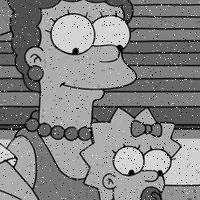

In [28]:
decode(sₒ, number_of_rows = number_of_rows, 
    number_of_cols = number_of_cols) |> img -> Gray.(img) # corrupted true image. This is what *we give the network*

Now that we have a starting memory encoded in the state vector $\mathbf{s}_{\circ}$, can we recover the original image? We are guaranteed an image, but maybe _not_ the correct one.
* _Implementation_: We implemented the modern Hopfield recovery algorithm above in [the `recover(...)` method](src/Compute.jl). This method takes our `model::MyModernHopfieldNetworkModel` instance, the initial configuration vector `sₒ::Array{Int32,1}`, and the maximum number `maxiterations::Int64`, and iteration tolerance parameter `ϵ::Float64`. 
* [The `recover(...)` method](src/Compute.jl) returns the recovered image in the e`s₁::Array{Float32,1}` variable, the image at each iteration in the `f::Dict{Int, Array{Float32,2}}` dictionary, and the probability of the image at each iteration in the `p::Dict{Int, Array{Float32,2}}` variable. The frames and probability dictionaries are indexed from `0`.

How many iterations did it take to converge? 

In [30]:
(s₁,f,p) = recover(model, sₒ, maxiterations = 10000, ϵ = 1e-16); # iterate until we hit stop condition

In [31]:
println("How many iterations: $(length(f))") # how many iterations did we need to converge?

How many iterations: 3


__Check__: Let's check to see if the recovered image is identical to the original image (not guaranteed). We can do this by checking the `s₁::Array{Float32,1}` variable against the original image.

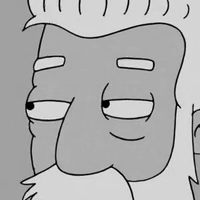

In [33]:
decode(s₁, number_of_rows = number_of_rows, 
        number_of_cols = number_of_cols) |> img -> Gray.(img) # After n iterations, this is what the network gave us back

__Hmmmm__. Sometimes this works (in the sense that we get the original image back), and sometimes it doesn't. Let's step through the frames and see what we see.

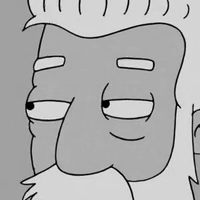

In [35]:
let
    n = 1; # frames indexed from 0!!!
    decode(f[n], number_of_rows = number_of_rows, 
        number_of_cols = number_of_cols) |> img -> Gray.(img) # After n iterations, this is what the network gave us back
end

### Hmmm. Sometimes, this works. What is going on?
Let's extract the iteration logic in [the `recover(...)` method](src/Compute.jl) and try to understand what is going on. 

#### Key points
The probability vector $\mathbf{p} = \texttt{softmax}(\beta\cdot\mathbf{X}^{\top}\mathbf{s})$ is computed using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). The softmax function takes a vector of real numbers and converts it into a probability distribution. The softmax function is defined as:
$$
\begin{align*}
p_{i} = \texttt{softmax}(x)_{i} = \frac{e^{x_{i}}}{\sum_{j=1}^{N}e^{x_{j}}}\quad\forall i\in\{1,\ldots,N\}
\end{align*}
$$
where $\mathbf{x}$ is the input vector, $p_{i}$ is the $i$-th element of the output vector, and $N$ is the number of elements in the input vector (number of pixels in the image). The next state vector $\mathbf{s}^{\prime} = \mathbf{X}\mathbf{p}$ is computed using the matrix multiplication of the image library $\mathbf{X}$ and the probability vector $\mathbf{p}$. 
* _Super interesting_: As the network's choice becomes more sure, the probability vector $\mathbf{p}\rightarrow{e}_{\star}$ converges to a single image, where $e_{\star}$ is a one-hot vector describing the chosen image (e.g., a standard basis vector).
* _Even more interesting_: The probability vector $\mathbf{p}$ is a probability distribution over the images in the library. Thus, it also describes the _mixing_ of the images in the library. It represents the weights in a _weighted sum of possible memories_.

Let's check out what is happening, especially as we increase/decrease the temperature $\beta$ parameter.

In [37]:
tmp, ptmp = let

    X = model.X;
    β = model.β;

    tmp = β*transpose(X)*sₒ;
    p = softmax(tmp)
    
    tmp,p
end

([100530.087890625, 122571.07421875, 115519.443359375, 126428.349609375, 90426.865234375, 123719.970703125, 128503.095703125, 80712.1337890625, 143694.90234375, 116545.615234375  …  108012.34375, 118236.66015625, 112409.4921875, 106685.25390625, 112922.5390625, 113696.474609375, 111061.904296875, 69972.783203125, 114777.744140625, 134469.765625], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [74]:
tmp

24-element Vector{Float64}:
 100530.087890625
 122571.07421875
 115519.443359375
 126428.349609375
  90426.865234375
 123719.970703125
 128503.095703125
  80712.1337890625
 143694.90234375
 116545.615234375
 111750.52734375
  84797.255859375
 105070.52734375
 102233.837890625
 108012.34375
 118236.66015625
 112409.4921875
 106685.25390625
 112922.5390625
 113696.474609375
 111061.904296875
  69972.783203125
 114777.744140625
 134469.765625

In [39]:
θ = let
    θ = zeros(number_of_images_to_memorize);
    x = tmp .- maximum(tmp)
    for i ∈ 1:number_of_images_to_memorize
        θ[i] = exp(x[i]);
    end
    Z = sum(θ);
    θ = θ*(1/Z);
end

24-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

## Next time.
In the lecture `L10a`, we'll explore another proto-neural network, [the Boltzmann machine](https://en.wikipedia.org/wiki/Boltzmann_machine). A [Boltzmann machine](https://en.wikipedia.org/wiki/Boltzmann_machine) is a stochastic neural network model consisting of symmetrically connected binary units that make probabilistic decisions about their states.
* The creator of the Boltzmann machine, [Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton), is one of the pioneers of deep learning and shared [the Nobel Prize in Physics in 2024](https://news.cornell.edu/stories/2024/10/john-hopfield-phd-58-wins-nobel-prize-physics) with [John Hopfield](https://en.wikipedia.org/wiki/John_Hopfield).

# Today?
That's a wrap! What are some of the interesting things we discussed today?